In [1]:
# !pip install SimPEG

In [2]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from SimPEG import Mesh, Utils, Solver
from scipy.constants import mu_0, epsilon_0
%matplotlib inline

# Sensitivity computuation for 1D magnetotelluric (MT)  problem

##  Purpose

With [SimPEG's](http://simpeg.xyz) mesh class, we discretize the sensitivity function for a 1D magnetotelluric problem. Rather than generating the full sensitivity matrix, we compute the forward (`Jvec`) and adjoint (`Jtvec`) functionals that can evalaute matrix-vector product. There are some milestones to be accomplished:

- Break apart senstivity function, $J_{\sigma}$ into to parts then derive each of them (using chain rules):

$$ 
J_{\sigma} = \frac{d P(u)}{d \sigma} = \frac{d P(u)}{d u} \frac{d u}{d \sigma}
$$

- Compute forward and adjoint sensitivity function: `Jvec` and `Jtvec`

- Test `Jvec` and `Jtvec`: Order test and Adjoint test

## Discretzation (forward simulation)

We define physical properties at cell centers, and stagger the electric and magnetic fields

- $\sigma$, $\mu$, $\epsilon$ : cell centers
- $E_x$: cell centers
- $H_y$: faces

<img src="./images/1DMT_discretize.png" width=200px> 

and use a finite difference approach to define the operators, this gives us the discrete system of equations

$$
\underbrace{
    \begin{bmatrix}
        \mathbf{Grad} & \imath \omega \mathbf{M}^{f}_{\mu} \\[0.3em]
        \mathbf{M}^{cc}_{\boldsymbol{\sigma}} & \mathbf{Div}           \\[0.3em]
    \end{bmatrix}
}_{\mathbf{A}}
\underbrace{
    \begin{bmatrix}
       \mathbf{e_x} \\[0.3em]
       \mathbf{h_y} \\[0.3em]
    \end{bmatrix}
}_{\mathbf{u}}
=
\underbrace{
    \begin{bmatrix}
       - \mathbf{B}\mathbf{e_x}^{BC} \\[0.3em]
       \boldsymbol{0} \\[0.3em]
    \end{bmatrix}
}_{\mathbf{rhs}}
$$

with 

- $\mathbf{e_x}$: Discrete $E_x$, on cell centers $[\text{nC} \times 1]$

- $\mathbf{h_y}$: Dicrete $H_x$, on cell faces $[(\text{nC}+1) \times 1]$

- $ \mathbf{Grad}$: Discrete gradient operator $[\text{nC} \times (\text{nC}+1)]$

- $ \mathbf{Div}$: Discrete divergence operator $[(\text{nC}+1) \times \text{nC}]$

- $\mathbf{M}^{f}_{\boldsymbol{\mu}} = \mathbf{diag}(\mathbf{Av^{cc2f}}  \boldsymbol{\mu})$ $[(\text{nC}+1) \times (\text{nC}+1)]$

- $\mathbf{M}^{cc}_{\boldsymbol{\boldsymbol{\sigma}}} = \mathbf{diag}(\boldsymbol{{\sigma}})$ $[\text{nC} \times \text{nC}]$. Here we are using the quasi-static assumption for brevity. 

- $\mathbf{B} \mathbf{e_x}^{BC}$ handles the boundary conditions

## What are the data?

The measured data in general can be defined as:

$$ \mathbf{d} = P(\mathbf{u}) $$

where $P(\cdot)$ is a evaluation functional which takes a solution vector $\mathbf{u}$ and ouputs data at a receiver location.

Here, we use impedace data (one could also consider using apparent resistivity and phase). The impedance is complex, so we treat the real and imaginary components of each as two separate data points

$$
Z_{xy} = -\frac{E_x}{H_y} = \text{Re}[Z_{xy}] + i ~\text{Im}[Z_{xy}]
$$


The impedance $Z_{xy}$ can be evaluated from the solution vector $\mathbf{u}$. We will evaluate data at $z=0m$. The solution vector we obtain from the forward simulation is: 

$$
\mathbf{u} = 
    \begin{bmatrix}
       \mathbf{e_x} \\[0.3em]
       \mathbf{h_y} \\[0.3em]
    \end{bmatrix}
$$

At the surface, we specified the boundary condition that $E_x(z=0) = 1$. So what we need $P(\dot)$ to accomplish is 
$$
Z_{xy}\big|_{z=0} = -\frac{1}{h_y(z=0)}
$$

Thus, $P(\dot)$ can be defined as an interpolation matrix that simply extracts the value of $h_y$ at the surface. We denote this matrix: $\mathbf{P}_{0}$ (Thinking in terms of matrices is very helpful when we get to the step of taking derivatives!)

$$\mathbf{d} = Z_{xy} = - \mathbf{P}_{0}\left(\frac{1}{\mathbf{u}}\right) $$

From complex-values $Z_{xy}$, we can compute real and imagniary part of the $Z_{xy}$ then the data can be defined as:

$$
\mathbf{d} =  \begin{bmatrix}
   \text{Re}[Z_{xy}]  \\[0.3em]
   \text{Im}[Z_{xy}]  \\[0.3em]
\end{bmatrix}
$$

We will set up an example and go through the steps to compute a datum. 

### Set up Mesh and Model

In [3]:
def skin_depth(sigma, f):
    """
    Depth at which the fields propagating through a homogeneous medium 
    have decayed by a factor of 1/e for a given frequency, f and conductivity, sigma
    """
    return 500./np.sqrt(sigma * f)

In [4]:
rho_half = 100.  # Resistivity of the halfspace in Ohm-m
sigma_half = 1./rho_half  # Conductivity is the inverse of conductivity
frequency = np.logspace(-3, 2, 25)  # frequencies at which to simulate the MT problem

skin_depth_min = skin_depth(sigma_half, frequency.max())
skin_depth_max = skin_depth(sigma_half, frequency.min())

print("The minimum skin depth is {:1.2f}m".format(skin_depth_min))
print("The maximum skin depth is {:1.2e}m".format(skin_depth_max))

The minimum skin depth is 500.00m
The maximum skin depth is 1.58e+05m


In [5]:
cs = skin_depth_min / 4.
core_extent = 5000. 
domain_extent = 2 * skin_depth_max

print("The smallest cell size is {:1.2f}m".format(cs))
print("The core region of the mesh extends {:1.2e}m".format(core_extent))
print("The mesh should extend at least {:1.2e}m".format(domain_extent))

The smallest cell size is 125.00m
The core region of the mesh extends 5.00e+03m
The mesh should extend at least 3.16e+05m


Add padding to extend sufficiently far

In [6]:
npad = 1  # start with 1 cell
padding_fact = 1.3  # the amount by which we will expand each cell of the padding

def padding_extent(npad):
    """
    given a number of padding cells, this computes how far the padding extends
    """
    padding_widths = cs*padding_fact**(np.arange(npad) + 1)
    return padding_widths.sum()

# keep adding padding until we are beyond the desired extent
padding_z = padding_extent(npad)
while padding_z < domain_extent:
    npad+=1
    padding_z = padding_extent(npad)
    
print("{:1.0f} padding cells extends {:1.2e}m > {:1.2e}m (2 skin depths)".format(
    npad, padding_extent(npad), domain_extent
))

25 padding cells extends 3.82e+05m > 3.16e+05m (2 skin depths)


In [7]:
ncz = np.ceil(core_extent / cs)  # number of cells in the core domain
hz = [(cs, npad, -1.3), (cs, ncz)]  # define how to construct the cell widths
mesh = Mesh.TensorMesh([hz], x0='N')  # construct a 1D Tensor Mesh

print("There are {:1.0f} cells in the mesh. The mest extends {:1.2e}m".format(
    ncz, mesh.hx.sum()
)) 

sigma = np.ones(mesh.nC) * sigma_half

There are 40 cells in the mesh. The mest extends 3.87e+05m


### Forward simulation function

Forward simulation function `dpred` takes conductivity model (`nCx1`), and frequency (`1x1`), and outputs real and imaginary part of the impedance, $Z_{xy}$ (`2x1`). By solving $\mathbf{A} \mathbf{u}=\mathbf{rhs}$, we compute solution vector $\mathbf{u}$, then evaluate real and imaginary part of impedance at $z=0$ ($\mathbf{d} = P(\mathbf{u})$). 

In [8]:
# Projection Matrix
P0 = sp.csr_matrix(
    (np.r_[1.], (np.r_[0], np.r_[mesh.nF+mesh.nC-1])), shape=(1, mesh.nF+mesh.nC)
         )

print(
    "The projection matrix has shape {} with {} non-zero entry at ({},{})".format(
    P0.shape, P0.nnz, P0.nonzero()[0][0], P0.nonzero()[1][0]
    )
)


The projection matrix has shape (1, 131) with 1 non-zero entry at (0,130)


In [9]:
def dpred(sigma, f=100.):
    
    # angular frequency
    omega = f*2.*np.pi
    
    # physical properties
    mu = np.ones(mesh.nC)*mu_0 # magnetic permeability values for all cells
    sigmahat = sigma.copy() # here we are ignoring displacement current
    
    # Grad 
    mesh.setCellGradBC([['dirichlet', 'dirichlet']]) # Setup boundary conditions
    Grad = mesh.cellGrad # Gradient matrix

    # MfMu
    Mmu = Utils.sdiag(mesh.aveCC2F * mu) 
    
    # Mccsigma
    Msighat = Utils.sdiag(sigmahat) 
    
    # Div
    Div = mesh.faceDiv # Divergence matrix
    
    # Right Hand Side
    B = mesh.cellGradBC  # a matrix for boundary conditions
    Exbc = np.r_[0., 1.] # boundary values for Ex

    # A-matrix
    A = sp.vstack([
        sp.hstack([Grad, 1j*omega*Mmu]), # Top row of A matrix
        sp.hstack((Msighat, Div)) # Bottom row of A matrix
    ])
    
    # Right-hand side
    rhs = np.r_[
        -B*Exbc, 
        np.zeros(mesh.nC)
    ] 

    Ainv = Solver(A) # Factor A matrix
    u = Ainv*rhs   # Solve A^-1 rhs = u

    # build the projection matrix, a sparse matrix that has 1 entry to grab the value of h_y at the surface
    P0 = sp.csr_matrix(
        (np.r_[1.], (np.r_[0], np.r_[len(u)-1])), shape=(1, len(u))
             )
    
    Zxy = - P0 * (1./(u))
    
    return np.r_[Zxy.real, Zxy.imag]

In [10]:
f = 100.
data = dpred(sigma, f=f)

print("At f={}Hz, we have two data. \nRe[Z] = {:1.3f}, Im[Z] = {:1.3f}".format(f, data[0], data[1]))

At f=100.0Hz, we have two data. 
Re[Z] = 0.196, Im[Z] = 0.202


## Sensitivity of datum with regard to $\sigma$:

The sensitivity function shows how much the data are changed due to changes in model paramters. Understanding how "sensitive" our data are to the model is important for survey design. It is essential that we be able to compute the sensitivity when using gradient-based optimization techniques, as the sensitivity gives us the direction in which to take a step and update the model as we search for a solution. 

The sensitivity function can be defined as 

$$ J_{\sigma} = \frac{d P(u)}{d \sigma}$$

The size of the sensitivity is $[nD \times n\sigma]$

To obtain above sensitivity function in discrete space, we first differentiate 

$$\mathbf{A}\mathbf{u} = \mathbf{rhs}$$

w.r.t ${\boldsymbol{\sigma}}$, which yields 

$$ \frac{d \mathbf{A}}{d {\boldsymbol{\sigma}}}\mathbf{u} +  \mathbf{A} \frac{d \mathbf{u} }{d {\boldsymbol{\sigma}}}=  0 $$

Rearranging and multiplyting by $\mathbf{A}^{-1}$ on both sides yields

$$ \frac{d \mathbf{u} }{d {\boldsymbol{\sigma}}}=  -\mathbf{A}^{-1}\frac{d \mathbf{A}}{d {\boldsymbol{\sigma}}}\mathbf{u} $$

Next, we need to include the evaluation, $\mathbf{d} = P(\mathbf{u})$ which is the operation taken on $\mathbf{u}$ to give us the data. From this, we obtain

$$ \mathbf{J}_{{\boldsymbol{\sigma}}}  = 
\frac{\partial P(\mathbf{u})}{\partial {\mathbf{u}}}\Big(\frac{d \mathbf{u} }{d {\boldsymbol{\sigma}}}\Big) = 
-\frac{\partial P(\mathbf{u})}{\partial {\mathbf{u}}} \Big(\mathbf{A}^{-1}\frac{d \mathbf{A}}{d {\boldsymbol{\sigma}}}\mathbf{u}\Big) $$

From this, there are two derivatives need to be computed:

1. $$\frac{d \mathbf{A}}{d \boldsymbol{\sigma}}\mathbf{u}=?$$

2. $$\frac{\partial P(\mathbf{u})}{\partial \mathbf{u}}=?$$

### First part of the sensitivity, $\frac{d \mathbf{A}}{d \boldsymbol{\sigma}}\mathbf{u}=?$
For $\frac{d \mathbf{A}}{d \boldsymbol{\sigma}}\mathbf{u}$, keep in mind that we are treating $\mathbf{u}$ as fixed and that 

$$
\mathbf{A}\mathbf{u} = 
    \begin{bmatrix}
        \mathbf{Grad} & \imath \omega \mathbf{M}^{f}_{\mu} \\[0.3em]
        \mathbf{M}^{cc}_{\boldsymbol{\sigma}} & \mathbf{Div}           \\[0.3em]
    \end{bmatrix} 
    \begin{bmatrix}
       \mathbf{e_x} \\[0.3em]
       \mathbf{h_y} \\[0.3em]
    \end{bmatrix}
$$

Here, we see that the only dependence on $\boldsymbol{\sigma}$ is in the matrix $\mathbf{M}^{cc}_{\hat{\boldsymbol{\sigma}}} = \mathbf{diag}(\boldsymbol{\sigma})$. So lets focus our attention on that block. We are taking the derivative of a Matrix-vector product (which is just a vector) with respect to the vector $\boldsymbol{\sigma}$, so the result should be a matrix. We write out the problem: 

$$
\frac{\partial}{\partial \boldsymbol{\sigma}} \mathbf{M}^{cc}_{\hat{\boldsymbol{\sigma}}}  \mathbf{e_x}^{fix} = \frac{\partial}{\partial \boldsymbol{\sigma}} \mathbf{diag}(\boldsymbol{\sigma}) \mathbf{e_x}^{fix}
$$

and since $\text{diag}(\mathbf{x})\mathbf{y} = \mathbf{diag}(\mathbf{y})\mathbf{x}$, we can interchange the roles of $\boldsymbol{\sigma}$ and $\mathbf{e_x}^{fix}$

$$
\frac{\partial}{\partial \boldsymbol{\sigma}} \mathbf{M}^{cc}_{\hat{\boldsymbol{\sigma}}}  \mathbf{e_x}^{fix} = \frac{\partial}{\partial \boldsymbol{\sigma}} \mathbf{diag}(\mathbf{e_x}^{fix}) \boldsymbol{\sigma}
$$

So the derivative is simply: 
$$
\frac{\partial}{\partial \boldsymbol{\sigma}} \mathbf{M}^{cc}_{\hat{\boldsymbol{\sigma}}}  \mathbf{e_x}^{fix} =\text{diag}(\mathbf{e_x}^{fix})
$$

Thus the full derivative is 
$$ 
\frac{d \mathbf{A}}{d \boldsymbol{\sigma}}\mathbf{u} =
\begin{bmatrix}
    \mathbf{0} \\[0.3em]
    \mathbf{diag}(\mathbf{e}_x) \\[0.3em]
\end{bmatrix}
$$

### Second part of the Sensitivity:  $\frac{\partial P(\mathbf{u})}{\partial \mathbf{u}}=?$
For the other one we consider when the data is defined as real and imaginary parts of $Z_{xy} = -\mathbf{P}_0\frac{1}{\mathbf{u}}$:

Taking derivative of $Z_{xy}$ w.r.t. $\mathbf{u}$ yields
$$
\frac{\partial Z_{
xy}}{\partial \mathbf{u}}=
\mathbf{P}_0\frac{1}{\mathbf{u}^2}
$$

$$ 
\frac{\partial P(\mathbf{u})}{\partial \mathbf{u}}=
\begin{bmatrix}
   \frac{\partial Re[Z_{xy}]}{\partial \mathbf{u}}  \\[0.3em]
   \frac{\partial Im[Z_{xy}]}{\partial \mathbf{u}}  \\[0.3em]
\end{bmatrix}  
=
\begin{bmatrix}
   Re[\mathbf{P}_0\frac{1}{\mathbf{u}^2}]  \\[0.3em]
   Im[\mathbf{P}_0\frac{1}{\mathbf{u}^2}]  \\[0.3em]
\end{bmatrix}          
$$


Now we can form sensitivity matrix $\mathbf{J}_{\sigma}$ by combining above equations:

$$ \mathbf{J}_{{\boldsymbol{\sigma}}}  = 
-\frac{\partial P(\mathbf{u})}{\partial {\mathbf{u}}} \Big(\mathbf{A}^{-1}\frac{d \mathbf{A}}{d {\boldsymbol{\sigma}}}\mathbf{u}\Big) $$

Deriving sensitivity for apparent resistivity and phase is possible, but this requires additional details hence, we focus on our attention to real and imaginary parts of impedance. 

## Compute Sensitivity function

We compute discretized sensitivity matrix, $\mathbf{J}_{\sigma}$ shown above. 

In [11]:
# angular frequency
omega = f*2*np.pi

# physical properties
sigma = np.ones(mesh.nC)*sigma_half # conductivity values for all cells
mu = np.ones(mesh.nC)*mu_0 # magnetic permeability values for all cells
sigmahat = sigma.copy()

# Grad 
mesh.setCellGradBC([['dirichlet', 'dirichlet']]) # Setup boundary conditions
Grad = mesh.cellGrad # Gradient matrix

# MfMu
Mmu = Utils.sdiag(mesh.aveCC2F * mu)

# Mccsigma
Msighat = Utils.sdiag(sigmahat) 

# Div
Div = mesh.faceDiv # Divergence matrix

# Right Hand Side
B = mesh.cellGradBC  # a matrix for boundary conditions
Exbc = np.r_[0., 1.] # boundary values for Ex

# A-matrix
A = sp.vstack([
    sp.hstack([Grad, 1j*omega*Mmu]), # Top row of A matrix
    sp.hstack((Msighat, Div)) # Bottom row of A matrix
])

# Right-hand side
rhs = np.r_[
    -B*Exbc, 
    np.zeros(mesh.nC)
] 

In [12]:
Ainv = Solver(A) # Factorize A matrix
u = Ainv*rhs   # Solve A^-1 rhs = u

Ex = u[:mesh.nC] # Extract Ex from uution vector u
Hy = u[mesh.nC:mesh.nC+mesh.nN] # Extract Hy from solution vector u    

P0 = sp.csr_matrix(
    (np.r_[1.], (np.r_[0], np.r_[len(u)-1])), shape=(1, len(u))
         )
P0 = P0.tocsr()

dAdsig_u = sp.vstack((Utils.spzeros(int(mesh.nC+1), mesh.nC), Utils.sdiag(Ex)))
dudsig = - (Ainv * (dAdsig_u.toarray()))
dZdsig = P0 * (Utils.sdiag(1./(u**2)) * dudsig)

J = np.vstack((dZdsig.real, dZdsig.imag))

#### Plot the sensitivity 

NameError: name 'core_inds' is not defined

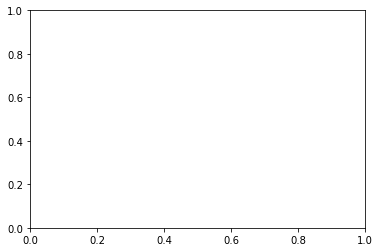

In [13]:
fig, ax = plt.subplots(1, 1)

core_inds = mesh.vectorCCx > -core_extent

ax.loglog(-mesh.vectorCCx[core_inds], abs(J[0, core_inds]), label="real")
ax.loglog(-mesh.vectorCCx[core_inds], abs(J[1, core_inds]), label="imag")

ax.grid(True)
ax.legend()
ax.set_xlabel("Logarithmic Depth (m)")
ax.set_ylabel("Sensitivity")  

## Compute sensitivity-vector products:

For the 1D MT problem, the sensitivity matrix ($N\times M$) is small, hence generating sensitivity is not be a big deal. However, for any 3D EM problem, generating the sensitivity matrix will require a huge amount of memory. To minimize that we only compute sensitivity-vector product. In forward case we compute:

$$ \mathbf{Jv} = \mathbf{J}_{\boldsymbol{\sigma}} \mathbf{v} $$

Similarly, in adjoint case, we compute

$$ \mathbf{Jtv} = \mathbf{J}_{\boldsymbol{\sigma}}^{T} \mathbf{v} $$

Computing $\mathbf{Jv}$ and $\mathbf{Jtv}$ are straight forward from above derivation. 

$$ \mathbf{J}_{{\boldsymbol{\sigma}}}^T \mathbf{v} 
=  - \left(\frac{d \mathbf{A}}{d {\boldsymbol{\sigma}}}\mathbf{u} \right)^T
\left(\mathbf{A}^{T}\right)^{-1} \frac{\partial P(\mathbf{u})}{\partial {\mathbf{u}}}^T \mathbf{v} $$

One function computes forward sensitivity-vector product as `Jvec` and the other function computes adjoint sensitivity-vector product are named as `Jtvec`. 

### Jvec

`Jvec` function takes conductivity ($\sigma$) and vector ($\mathbf{v}$), and computes sensitivity-vector product  at a given frequency. 

In [ ]:
def Jvec(sigma, v, f=100.):
    mu = np.ones(mesh.nC)*mu_0 # magnetic permeability values for all cells
    epsilon = np.ones(mesh.nC)*epsilon_0 # dielectric constant values for all cells
    omega = 2*np.pi*f # Angular frequency (rad/s)
    sigmahat = sigma # Assume sigmahat = sigma
    
    Div = mesh.faceDiv # Divergence matrix
    mesh.setCellGradBC([['dirichlet', 'dirichlet']]) # Setup boundary conditions
    Grad = mesh.cellGrad # Gradient matrix
    B = mesh.cellGradBC  # a matrix for boundary conditions
    Exbc = np.r_[0., 1.] # boundary values for Ex
    Msighat = Utils.sdiag(sigmahat) 
    Mmu = Utils.sdiag(mesh.aveCC2F * mu) 

    # A-matrix
    A = sp.vstack([
        sp.hstack([Grad, 1j*omega*Mmu]), # Top row of A matrix
        sp.hstack((Msighat, Div)) # Bottom row of A matrix
    ])

    # Right-hand side
    rhs = np.r_[
        -B*Exbc, 
        np.zeros(mesh.nC)
    ] 

    Ainv = Solver(A) # Factorize A matrix
    u = Ainv*rhs   # Solve A^-1 rhs = u
    Ex = u[:mesh.nC] # Extract Ex from uution vector u
    Hy = u[mesh.nC:mesh.nC+mesh.nN] # Extract Hy from solution vector u    
    
    P0 = sp.csr_matrix(
        (np.r_[1.], (np.r_[0], np.r_[len(u)-1])), shape=(1, len(u))
             )
    P0 = P0.tocsr()
    Zxy = - 1./(P0*u)

    dAdsig_u_v = np.r_[np.zeros_like(Hy), Utils.sdiag(Ex)*v]
    dudsig_v = - (Ainv * (dAdsig_u_v))
    dZdsig_v = P0 * (Utils.sdiag(1./(u**2)) * dudsig_v)
    dZrdsig_v = dZdsig_v.real
    dZidsig_v = dZdsig_v.imag
    return np.r_[dZrdsig_v, dZidsig_v]

### Order test: Jvec

We have written the `Jvec` function, but how do we make sure this function is working properly? 

Let's consdier a predicted data $ d = \mathcal{F}[\sigma + \triangle \sigma] $.
Applying Taylor's expansion yields

$$ 
\mathcal{F}[\sigma + \triangle \sigma] = \mathcal{F}[\sigma]
+\frac{d \mathcal{F}}{d \sigma} \triangle \sigma 
+ \mathcal{O}(\triangle \sigma )^2
$$ 

By rearranging aboe equation, we can consider two misfit functions:

$$
f^1 = \|
\mathcal{F}[\sigma + \triangle \sigma] -\mathcal{F}[\sigma] \|
$$

$$
f^2 = \|
\mathcal{F}[\sigma + \triangle \sigma] -\mathcal{F}[\sigma]
-\frac{d \mathcal{F}}{d \sigma} \triangle \sigma \|
$$

The first misfit function is supposed to have 1st order accuracy, but the other should be 2nd order accuracy. By using `SimPEG`'s `Tests` class we compute this two misfits, and check the accuracy. 

In [ ]:
from SimPEG import Tests
def derChk(m):
    return [dpred(m), lambda mx: Jvec(m, mx)]
Tests.checkDerivative(derChk, sigma, plotIt=False, num=3, eps=1e-20, dx=sigma*3)

### Jtvec

The below function takes conductivity ($\sigma$) and vector ($\mathbf{v}$), and computes adjoint sensitivity-vector product (`Jtvec`) at a given frequency. 

In [ ]:
def misfit(sigma, dobs=None):
    r = dpred(sigma) - dobs
    return 0.5 * np.linalg.norm(r)**2

def Jtvec(sigma, v, dtype="ri"):
    f = 100.
    mu = np.ones(mesh.nC)*mu_0 # magnetic permeability values for all cells
    epsilon = np.ones(mesh.nC)*epsilon_0 # dielectric constant values for all cells
    omega = 2*np.pi*f # Angular frequency (rad/s)
    sigmahat = sigma # Assume sigmahat = sigma

    Div = mesh.faceDiv # Divergence matrix
    mesh.setCellGradBC([['dirichlet', 'dirichlet']]) # Setup boundary conditions
    Grad = mesh.cellGrad # Gradient matrix
    B = mesh.cellGradBC  # a matrix for boundary conditions
    Exbc = np.r_[0., 1.] # boundary values for Ex
    Msighat = Utils.sdiag(sigmahat) 
    Mmu = Utils.sdiag(mesh.aveCC2F * mu) 

    tempUp = sp.hstack((Grad, 1j*omega*Mmu)) # Top row of A matrix
    tempDw = sp.hstack((Msighat, Div)) # Bottom row of A matrix
    A = sp.vstack((tempUp, tempDw)) # Full A matrix
    rhs = np.r_[-B*Exbc, np.zeros(mesh.nC)] # Right-hand side   

    Ainv = Solver(A) # Factorize A matrix
    u = Ainv*rhs   # Solve A^-1 rhs = u
    Ex = u[:mesh.nC] # Extract Ex from uution vector u
    Hy = u[mesh.nC:mesh.nC+mesh.nN] # Extract Hy from solution vector u    
    P0 = sp.coo_matrix(
        (np.r_[1.], (np.r_[0], np.r_[len(u)-1])), shape=(1, len(u))
             )
    P0 = P0.tocsr()
    Zxy = - 1./(P0*u)    
    ATinv = Solver(A.T) # Factorize A matrix        
    
    PTvr = (P0.T*np.r_[v[0]]).astype(complex)
    PTvi = P0.T*np.r_[v[1]]*-1j
    dZrduT_v = Utils.sdiag((1./(u**2)))*PTvr
    dZiduT_v = Utils.sdiag((1./(u**2)))*PTvi

    dAdsiguT = sp.hstack((Utils.spzeros(mesh.nC, mesh.nN), Utils.sdiag(Ex)))

    dZrdsigT_v = - (dAdsiguT*(ATinv*dZrduT_v)).real
    dZidsigT_v = - (dAdsiguT*(ATinv*dZiduT_v)).real        
    return dZrdsigT_v + dZidsigT_v

### Order test: Jtvec

Similarly, `Jtvec` function has to be tested. For this, in this turn we consider a data msifit function:

$$
\phi_d = \frac{1}{2}\|
\mathcal{F}[\sigma] - \mathbf{d}^{obs}
\|^2_2
=\frac{1}{2} \mathbf{r}^T\mathbf{r},
$$

where residual is $\mathbf{r} = \mathcal{F}[\sigma] - \mathbf{d}^{obs}$. 

By taking derivative w.r.t $\sigma$, we obtain

$$
\frac{d \phi_d}{d \sigma} = \mathbf{J}_{\sigma}^T \mathbf{r}
$$

- Note that this is basically a gradient direction, and for first order optimization method such as steepest descent, we only needs this function that is only `Jvec` is required. 

Then applying taylor expansion to $\phi_d$ yields

$$ 
\phi_d[\sigma + \triangle \sigma] = \phi_d[\sigma]
+\frac{d \phi_d}{d \sigma} \triangle \sigma 
+ \mathcal{O}(\triangle \sigma )^2
$$ 

And similarly, we can consider two misfit functions:

$$
\phi_d^1 = \|
\phi_d[\sigma + \triangle \sigma] -\phi_d[\sigma] \|
$$

$$
\phi_d^2 = \|
\phi_d[\sigma + \triangle \sigma] -\phi_d[\sigma]
-\frac{d \phi_d}{d \sigma} \triangle \sigma \|
$$

The first data misfit function is supposed to have 1st order accuracy, but the other should be 2nd order accuracy. By using `SimPEG`'s `Tests` class we compute this two misfits, and check the accuracy. 

In [ ]:
sigma0 = sigma*3
dobs_ri = dpred(sigma)
r = dpred(sigma0) - dobs_ri 

Tests.checkDerivative(
    lambda m: [misfit(m, dobs=dobs_ri), Jtvec(m, r)],
    sigma0,
    plotIt=False,
    num=5
)

## Adjoint test

Both `Jvec` and `Jtvec` functions have passed the order test. These tests are necessary, but not sufficient. 
To test that both `Jvec` and `Jtvec` are consistent, we perform adjoint test. Consdier two random vectors: $\mathbf{w}$ and $\mathbf{v}$, then we can evalaute

$$
\mathbf{w}^T \mathbf{J}_{\sigma} \mathbf{v}, 
$$

which will be a scalar value. Adjoint of above proucts is 

$$
\mathbf{v}^T \mathbf{J}_{\sigma}^T \mathbf{w}, 
$$

They should have same value: $\mathbf{w}^T \mathbf{J}_{\sigma} \mathbf{v}=\mathbf{v}^T \mathbf{J}_{\sigma}^T \mathbf{w}$. We evaluate $\mathbf{w}^T \mathbf{J}_{\sigma} \mathbf{v}$ and $\mathbf{v}^T \mathbf{J}_{\sigma}^T \mathbf{w}$ using `Jvec` and `Jtvec`, respectively, and check if they are outputing same values. 

In [ ]:
v = np.random.rand(mesh.nC)
w = np.random.rand(dobs_ri.shape[0])
wtJv = w.dot(Jvec(sigma0, v))
vtJtw = v.dot(Jtvec(sigma0, w))
passed = np.abs(wtJv - vtJtw) < 1e-10
print('Adjoint Test', np.abs(wtJv - vtJtw), passed)